In [1]:
import os
import glob
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
import os

path_to = ".."

# Set your local paths to each folder
ipd_val_dir = f'{path_to}\ipd_val'       # Validation images and labels
ipd_base_dir = f'{path_to}\ipd_base'     # Base archive: camera parameters, dataset_info, etc.
ipd_models_dir = f'{path_to}\ipd_models' # 3D object models (PLY files)

# List contents of each directory
print("Contents of ipd_val:")
print(os.listdir(ipd_val_dir))
print("\nContents of ipd_base:")
print(os.listdir(ipd_base_dir))
print("\nContents of ipd_models:")
print(os.listdir(ipd_models_dir))


Contents of ipd_val:
['val']

Contents of ipd_base:
['camera_cam1.json', 'camera_cam2.json', 'camera_cam3.json', 'camera_photoneo.json', 'dataset_info.md', 'test_targets_bop19.json', 'test_targets_bop24.json', 'test_targets_multiview_bop25.json']

Contents of ipd_models:
['models', 'models_eval']


In [3]:
import os
import re
import json
import numpy as np

def get_image_id(filename):
    """
    Extract the numeric ID from a filename like '000123.png' -> '123'
    or '000000.png' -> '0'
    """
    return re.sub(r'\D', '', filename)

def parse_scene_jsons(scene_path, scene_id):
    """
    Parse all the JSON files in a single scene directory (scene_path).
    Returns a dictionary with keys: 'cam_params', 'gt', 'gt_info'.
    Each of these is a dict keyed by camera index -> dict keyed by image ID.
    """
    # Initialize sub-dicts for camera parameters, ground-truth poses, and gt info
    cam_params = {i: {} for i in range(10)}  # allow up to cam9 if needed
    gt_poses   = {i: {} for i in range(10)}
    gt_info    = {i: {} for i in range(10)}

    json_files = sorted(f for f in os.listdir(scene_path) if f.endswith(".json"))
    for json_file in json_files:
        file_path = os.path.join(scene_path, json_file)
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
        except Exception as e:
            print(f"[Scene {scene_id}] Error loading {json_file}: {e}")
            continue

        # We look for camera index X in the filename (scene_camera_camX, scene_gt_camX, etc.)
        # A simple approach is to search for "cam" followed by a digit.
        match = re.search(r'_cam(\d+)', json_file)
        if not match:
            continue  # no camera index found in the filename
        cam_idx = int(match.group(1))

        # Check which type of file it is
        if "scene_camera_cam" in json_file:
            # data is a dict of {img_id: {cam_K, cam_R_w2c, cam_t_w2c, depth_scale}}
            for img_id_str, cam_params_data in data.items():
                try:
                    cam_K = np.array(cam_params_data["cam_K"]).reshape(3, 3)
                    cam_R_w2c = np.array(cam_params_data["cam_R_w2c"]).reshape(3, 3)
                    cam_t_w2c = np.array(cam_params_data["cam_t_w2c"])
                    depth_scale = cam_params_data["depth_scale"]
                except Exception as e:
                    print(f"[Scene {scene_id}] Error parsing camera params for img {img_id_str}: {e}")
                    continue

                cam_params[cam_idx][img_id_str] = {
                    "cam_K": cam_K,
                    "cam_R_w2c": cam_R_w2c,
                    "cam_t_w2c": cam_t_w2c,
                    "depth_scale": depth_scale
                }

        elif "scene_gt_cam" in json_file:
            # data is a dict of {img_id: [list of object annotations]}
            for img_id_str, annotations in data.items():
                pose_list = []
                for ann in annotations:
                    try:
                        R_m2c = np.array(ann["cam_R_m2c"]).reshape(3, 3)
                        t_m2c = np.array(ann["cam_t_m2c"])
                        obj_id = ann["obj_id"]
                    except Exception as e:
                        print(f"[Scene {scene_id}] Error parsing GT pose for img {img_id_str}: {e}")
                        continue
                    pose_list.append({
                        "cam_R_m2c": R_m2c,
                        "cam_t_m2c": t_m2c,
                        "obj_id": obj_id
                    })
                gt_poses[cam_idx][img_id_str] = pose_list

        elif "scene_gt_info_cam" in json_file:
            # data is a dict of {img_id: [list of info entries]}
            for img_id_str, info_entries in data.items():
                gt_info[cam_idx][img_id_str] = info_entries

    return {
        "cam_params": cam_params,
        "gt": gt_poses,
        "gt_info": gt_info
    }

def parse_all_scenes(val_path):
    """
    Iterates over all scene folders in val_path (e.g. 000000, 000001, ...),
    parses their JSON files, and returns a dictionary keyed by scene ID.
    """
    scene_dict = {}
    if not os.path.exists(val_path):
        print(f"Val path '{val_path}' does not exist.")
        return scene_dict

    # Scenes are typically named as 6-digit folders: 000000, 000001, ...
    scene_folders = sorted(d for d in os.listdir(val_path) if d.isdigit())
    for scene_id in scene_folders:
        scene_path = os.path.join(val_path, scene_id)
        if not os.path.isdir(scene_path):
            continue

        print(f"Parsing scene {scene_id} at {scene_path}")
        scene_data = parse_scene_jsons(scene_path, scene_id)
        scene_dict[scene_id] = scene_data

    return scene_dict


In [4]:
import cv2
import matplotlib.pyplot as plt
import os

def visualize_image_with_bbox(img_path, bbox_list, scene_id="000000", cam_idx=1):
    """
    Loads an image and draws bounding boxes from bbox_list,
    adding additional info like object label (index), center position,
    and visibility fraction.

    Parameters:
        img_path (str): Path to the image on disk.
        bbox_list (list): A list of bounding-box dictionaries for that image,
                          e.g. from all_scenes[scene_id]["gt_info"][cam_idx][img_id].
        scene_id (str): The scene identifier (for debugging/labeling).
        cam_idx (int): The camera index (for debugging/labeling).
    """
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return
    
    print("Image shape:", img.shape)  # Debug info
    
    # Convert BGR to RGB for matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw each bounding box from bbox_list
    for idx, obj_info in enumerate(bbox_list):
        # Prefer 'bbox_visib' if available; otherwise fallback to 'bbox_obj'
        if 'bbox_visib' in obj_info:
            x, y, w, h = obj_info['bbox_visib']
        elif 'bbox_obj' in obj_info:
            x, y, w, h = obj_info['bbox_obj']
        else:
            continue

        # Debug: print the bounding box coordinates
        print(f"Bounding box {idx}: x={x}, y={y}, w={w}, h={h}")

        # Convert to integers for drawing
        x, y, w, h = map(int, [x, y, w, h])
        
        # Draw a red rectangle (thickness=3)
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 3)
        
        # Compute center of the bounding box
        center_x, center_y = x + w // 2, y + h // 2
        
        # Visibility fraction if present
        visib_fract = obj_info.get('visib_fract', None)
        vis_text = f"vis: {visib_fract:.2f}" if visib_fract is not None else "vis: N/A"
        
        # Label text
        label_text = f"Obj {idx} | pos: ({center_x},{center_y}) | {vis_text}"
        
        # Put text just above the bounding box
        cv2.putText(img, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2, cv2.LINE_AA)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Scene {scene_id}, Camera {cam_idx}: {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()


Parsing scene 000000 at ..\ipd_val/val\000000
Parsing scene 000001 at ..\ipd_val/val\000001
Parsing scene 000002 at ..\ipd_val/val\000002
Parsing scene 000003 at ..\ipd_val/val\000003
Parsing scene 000004 at ..\ipd_val/val\000004
Parsing scene 000005 at ..\ipd_val/val\000005
Parsing scene 000006 at ..\ipd_val/val\000006
Parsing scene 000007 at ..\ipd_val/val\000007
Parsing scene 000008 at ..\ipd_val/val\000008
Parsing scene 000009 at ..\ipd_val/val\000009
Parsing scene 000010 at ..\ipd_val/val\000010
Parsing scene 000011 at ..\ipd_val/val\000011
Parsing scene 000012 at ..\ipd_val/val\000012
Parsing scene 000013 at ..\ipd_val/val\000013
Parsing scene 000014 at ..\ipd_val/val\000014
Found 3 bounding box entries for scene 000008, cam 3, image 0
Image shape: (2160, 3840, 3)
Bounding box 0: x=1825.0, y=303.0, w=233.0, h=397.0
Bounding box 1: x=1919.0, y=1075.0, w=386.0, h=157.0
Bounding box 2: x=2562.0, y=39.0, w=339.0, h=270.0


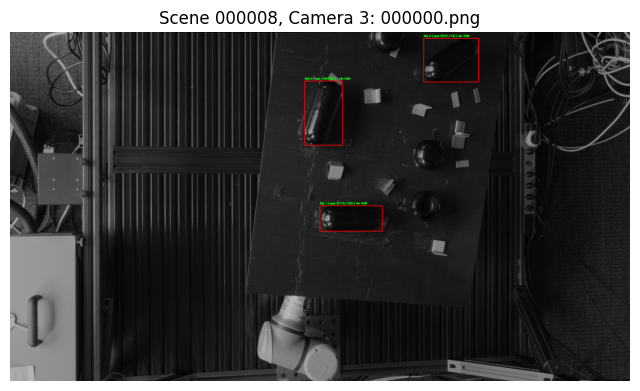

In [ ]:
all_scenes = parse_all_scenes(f"{ipd_val_dir}/val")

scene_id = "000008"
cam_idx = 3
img_id_str = "0"

rgb_dir = os.path.join(ipd_val_dir, "val", scene_id, f"rgb_cam{cam_idx}")
img_filename = f"{img_id_str.zfill(6)}.png"  # e.g. "000000.png"
img_path = os.path.join(rgb_dir, img_filename)

if (scene_id in all_scenes 
    and cam_idx in all_scenes[scene_id]["gt_info"]
    and img_id_str in all_scenes[scene_id]["gt_info"][cam_idx]):
    
    bbox_list = all_scenes[scene_id]["gt_info"][cam_idx][img_id_str]
    print(f"Found {len(bbox_list)} bounding box entries for scene {scene_id}, cam {cam_idx}, image {img_id_str}")
else:
    bbox_list = []
    print(f"No bounding box info found for scene {scene_id}, cam {cam_idx}, image {img_id_str}")

visualize_image_with_bbox(img_path, bbox_list, scene_id, cam_idx)
